In [3]:
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# 1. Introduction

We are going to build a deep neural network in order to predict if fraud is being comitted. 

In [6]:
dataset = pd.read_csv('clean_fraud_dataset.csv')

In [7]:
Y = dataset["isFraud"]
X = dataset.drop(["isFraud", "isFlaggedFraud"], axis = 1)

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_dev, X_test, Y_dev, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

# In deep learning we would use a smaller test size, but here for computation reasons we work with a 
# smaller training set and an overly large test set

In [9]:
X_train = preprocessing.scale(X_train)
X_test = preprocessing.scale(X_test)
X_dev = preprocessing.scale(X_dev)

# 2. Setting up Neural Network

In [10]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

In [153]:
def make_model(metrics = METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    
    model = keras.Sequential([keras.layers.Dense(16, 
                                                 activation='relu',
                                                 input_shape=(X_train.shape[-1],)), 
                              keras.layers.Dropout(0.), 
                              keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),])
    
    model.compile(optimizer=keras.optimizers.Adam(lr=5e-3), #begonnen aan 1e-3
                  loss=keras.losses.BinaryCrossentropy(), 
                  metrics=metrics)
    
    return model

In [154]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=20, # Begonnen aan 10 maar recall en AUC bleven nog verbeteren dus naar 15 gebracht
    mode='max',
    restore_best_weights=True)

In [155]:
model = make_model()
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_113 (Dense)            (None, 16)                176       
_________________________________________________________________
dropout_72 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_114 (Dense)            (None, 1)                 17        
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [145]:
model.predict(X_train[:10])

array([[0.6017297 ],
       [0.79942584],
       [0.7900761 ],
       [0.78288704],
       [0.5156152 ],
       [0.80122226],
       [0.6096559 ],
       [0.80959326],
       [0.766242  ],
       [0.39094865]], dtype=float32)

### Set correct inital bias

In [146]:
results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.3688


In [147]:
fraud_distribution = Y_train.value_counts()
pos = fraud_distribution[1]
neg = fraud_distribution[0]


initial_bias = np.log([pos/neg])
initial_bias

array([-6.64774739])

In [148]:
model = make_model(output_bias = initial_bias)
model.predict(X_train[:10])

array([[0.00161159],
       [0.00217878],
       [0.00219273],
       [0.00130974],
       [0.00225351],
       [0.00206085],
       [0.00217201],
       [0.00194333],
       [0.00187842],
       [0.00326428]], dtype=float32)

In [149]:
results = model.evaluate(X_train, Y_train, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0136


In [150]:
# To make the various training runs more comparable, keep this initial model's weights 
# in a checkpoint file, and load them into each model before training.

initial_weights = os.path.join(tempfile.mkdtemp(),'initial_weights')
model.save_weights(initial_weights)

### Confirm that the bias fix helps
Before moving on, confirm quick that the careful bias initialization actually helped.

Train the model for 20 epochs, with and without this careful initialization, and compare the losses:

In [106]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_dev, Y_dev), 
    verbose=0)

In [107]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(X_dev, Y_dev), 
    verbose=0)

In [108]:
def plot_loss(history, label, n):
  # Use a log scale to show the wide range of values.
      
    plt.semilogy(history.epoch,  history.history['loss'],
               color=colors[n], label='Train '+label)
  
    plt.semilogy(history.epoch,  history.history['val_loss'],
          color=colors[n], label='Val '+label,
          linestyle="--")
    plt.xlabel('Epoch')
    
    plt.ylabel('Loss')
  
    plt.legend()

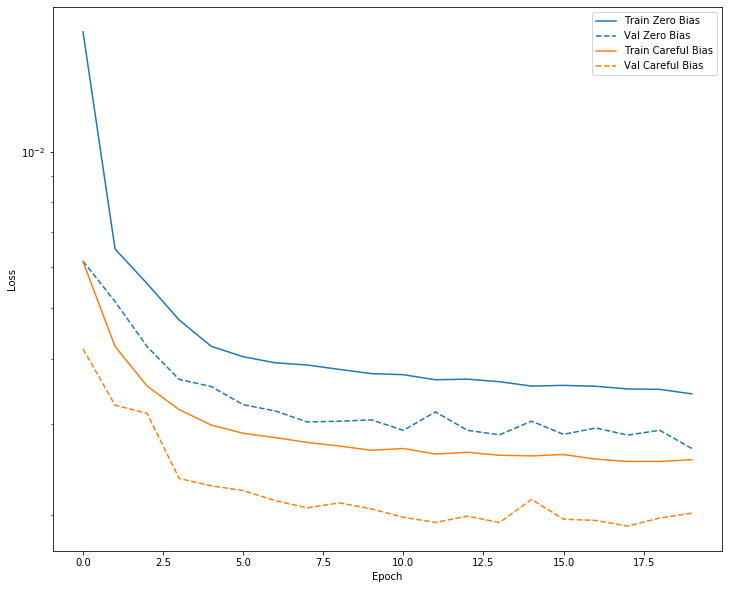

In [109]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

## Train the model

In [156]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_train,
    Y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(X_dev, Y_dev))

Train on 5090096 samples, validate on 636262 samples
Epoch 1/100
5090096/5090096 [==============================] - 16s 3us/sample - loss: 0.0044 - tp: 2282.0000 - fp: 106.0000 - tn: 5083397.0000 - fn: 4311.0000 - accuracy: 0.9991 - precision: 0.9556 - recall: 0.3461 - auc: 0.8923 - val_loss: 0.0032 - val_tp: 402.0000 - val_fp: 29.0000 - val_tn: 635405.0000 - val_fn: 426.0000 - val_accuracy: 0.9993 - val_precision: 0.9327 - val_recall: 0.4855 - val_auc: 0.9307
Epoch 2/100
5090096/5090096 [==============================] - 13s 2us/sample - loss: 0.0032 - tp: 3276.0000 - fp: 137.0000 - tn: 5083366.0000 - fn: 3317.0000 - accuracy: 0.9993 - precision: 0.9599 - recall: 0.4969 - auc: 0.9284 - val_loss: 0.0029 - val_tp: 410.0000 - val_fp: 5.0000 - val_tn: 635429.0000 - val_fn: 418.0000 - val_accuracy: 0.9993 - val_precision: 0.9880 - val_recall: 0.4952 - val_auc: 0.9465
Epoch 3/100
5090096/5090096 [==============================] - 14s 3us/sample - loss: 0.0029 - tp: 3555.0000 - fp: 162.0000 

Epoch 21/100
5090096/5090096 [==============================] - 13s 3us/sample - loss: 0.0021 - tp: 4377.0000 - fp: 210.0000 - tn: 5083293.0000 - fn: 2216.0000 - accuracy: 0.9995 - precision: 0.9542 - recall: 0.6639 - auc: 0.9644 - val_loss: 0.0018 - val_tp: 572.0000 - val_fp: 27.0000 - val_tn: 635407.0000 - val_fn: 256.0000 - val_accuracy: 0.9996 - val_precision: 0.9549 - val_recall: 0.6908 - val_auc: 0.9803
Epoch 22/100
5090096/5090096 [==============================] - 14s 3us/sample - loss: 0.0021 - tp: 4410.0000 - fp: 211.0000 - tn: 5083292.0000 - fn: 2183.0000 - accuracy: 0.9995 - precision: 0.9543 - recall: 0.6689 - auc: 0.9648 - val_loss: 0.0018 - val_tp: 558.0000 - val_fp: 18.0000 - val_tn: 635416.0000 - val_fn: 270.0000 - val_accuracy: 0.9995 - val_precision: 0.9688 - val_recall: 0.6739 - val_auc: 0.9710
Epoch 23/100
5090096/5090096 [==============================] - 14s 3us/sample - loss: 0.0021 - tp: 4394.0000 - fp: 214.0000 - tn: 5083289.0000 - fn: 2199.0000 - accuracy: 0.

Epoch 00040: early stopping


In [112]:
def plot_metrics(history):
    metrics =  ['loss', 'auc', 'precision', 'recall']
    
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'auc':
            plt.ylim([0.8,1])
        else:
            plt.ylim([0,1])

        plt.legend()

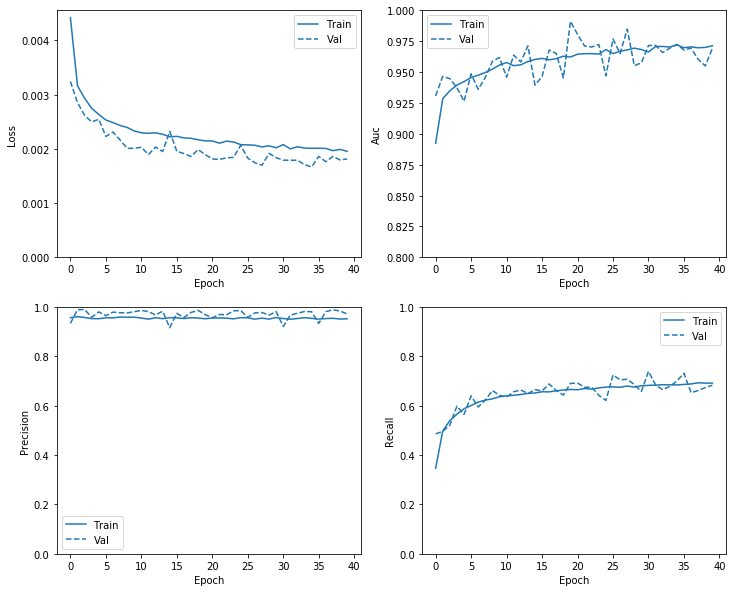

In [157]:
plot_metrics(baseline_history)

## Model assessment

In [5]:
assessment_factors = ['learning_rate', 'L1', 'Dropout_L1', 'L2', 'Dropout_L2', 'L3', 'Dropout_L3', 'L4', 'Early_Stopping', 'loss', 'acc', 'prec', 'recall', 'auc', 'loss_val', 'acc_val', 'prec_val', 'recall_val', 'auc_val']
df_assessment = pd.DataFrame(columns=assessment_factors)
df_assessment

,learning_rate,L1,Dropout_L1,L2,Dropout_L2,L3,Dropout_L3,L4,Early_Stopping,loss,acc,prec,recall,auc,loss_val,acc_val,prec_val,recall_val,auc_val


In [158]:
assessment = ['0,005', 16, 0., 1, None, None, None, None, 20, 0.0020, 0.9996, 0.9511, 0.6907, 0.9712, 0.0018, 0.9996, 0.9708, 0.6824, 0.9689]
df_assessment.loc[len(df_assessment)] = assessment
df_assessment

,learning_rate,L1,Dropout_L1,L2,Dropout_L2,L3,Dropout_L3,L4,Early_Stopping,loss,acc,prec,recall,auc,loss_val,acc_val,prec_val,recall_val,auc_val
0,"0,001",16,0.25,1,NaN,None,None,None,20,0.0021,0.9995,0.9491,0.6668,0.9726,0.0017,0.9996,0.9876,0.6751,0.9759
1,"0,001",16,None,1,NaN,None,None,None,20,0.0018,0.9996,0.9745,0.6954,0.9812,0.0016,0.9996,0.9896,0.6920,0.9818
2,"0,001",16,0.25,32,0.25,1,None,None,10,0.0024,0.9995,0.9259,0.6367,0.9541,0.0020,0.9995,0.9923,0.6232,0.9615
3,"0,001",16,0.25,8,0.25,1,None,None,10,0.0026,0.9994,0.9240,0.6255,0.9559,0.0019,0.9996,0.9666,0.6981,0.9779
4,"0,001",16,0,8,0,1,None,None,20,0.0018,0.9996,0.9611,0.7080,0.9747,0.0017,0.9996,0.9965,0.6884,0.9647
5,"0,0025",16,0,8,0,1,None,None,20,0.0018,0.9996,0.9475,0.7118,0.9715,0.0019,0.9996,0.9150,0.7536,0.9689
6,"0,0025",16,0,1,None,None,None,None,20,0.0018,0.9996,0.9605,0.7003,0.9779,0.0017,0.9996,0.9794,0.6884,0.9799
7,"0,005",16,0,1,None,None,None,None,20,0.0020,0.9996,0.9511,0.6907,0.9712,0.0018,0.9996,0.9708,0.6824,0.9689
